In [1]:
import pandas as pd
import numpy as np
import glob
import os

from scipy.stats import norm, sem
from scipy.optimize import curve_fit
import scipy.signal
import scipy.signal.windows  
scipy.signal.gaussian = scipy.signal.windows.gaussian
import pymc as pm
import arviz as az
from metadpy.utils import trials2counts
from metadpy.mle import fit_metad, metad
from collections import Counter
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None)

In [3]:
csv_dir = "data/"
csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))

In [4]:
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

In [5]:
df['soa_offset'] = round((df['soa_ms'] - df['threshold']) / 7)

In [6]:
df.head()

,subj,trial,soa_ms,catch_trial,detect_yn,confidence,threshold,soa_offset
0,Alex,0,69.575979,False,False,1,49.0,3.0
1,Alex,1,55.660783,False,True,3,49.0,1.0
2,Alex,2,55.660783,False,True,4,49.0,1.0
3,Alex,3,34.787990,False,False,2,49.0,-2.0
4,Alex,4,76.533577,False,True,4,49.0,4.0


## Calculate d' and meta-d' Scores

In [7]:

def counts_8(trials, conf_col="confidence"):
    """
    Return nR_S1, nR_S2 as 8-element int lists, already +1 padded.
    Order follows Maniscalco & Lau:    R=S1, conf K..1 | R=S2, conf 1..K
    """
    # initialise every cell with 1  (pseudo-count)
    nR_S1 = [1]*8
    nR_S2 = [1]*8

    for _, row in trials.iterrows():
        s       = row.signal          # 0 or 1
        respS2  = row.detect_yn       # 0=“S1”  1=“S2”
        c       = int(row[conf_col])  # 1..4
        if respS2 == 0:               # responded “S1”
            idx = 4-c                 # conf 4→0, 3→1, 2→2, 1→3
        else:                         # responded “S2”
            idx = 3+c                 # conf 1→4, 2→5, 3→6, 4→7
        if s == 0:
            nR_S1[idx] += 1
        else:
            nR_S2[idx] += 1
    return nR_S1, nR_S2

In [8]:
df["signal"]  = (~df["catch_trial"]).astype(int)
df["resp"]    = df["detect_yn"].astype(int)
df["correct"] = (df["resp"] == df["signal"]).astype(int)

rows = []
for (subj, soa), grp in df.groupby(["subj","soa_offset"]):
    # -------- d′ ----------
    H  = grp.query("signal==1 & resp==1").shape[0]
    FA = grp.query("signal==0 & resp==1").shape[0]
    n_sig   = grp.query("signal==1").shape[0]
    n_noise = grp.query("signal==0").shape[0]
    dprime  = norm.ppf((H+0.5)/(n_sig+1)) - norm.ppf((FA+0.5)/(n_noise+1))

    # -------- meta-d′ ----------
    try:
        # Pass the group DataFrame directly
        meta = metad(data=grp,  # Pass the DataFrame for the current group
                    stimuli="signal",
                    accuracy="correct",
                    confidence="confidence",
                    nRatings=4,
                    padding=True,  # Let metadpy handle padding
                    verbose=0
                    )
        meta_d = float(meta.loc[0, "meta_d"])
    except Exception as e:
        meta_d = np.nan

    rows.append(dict(subj=subj, soa_offset=soa,
                     dprime=dprime, meta_dprime=meta_d))

summary = pd.DataFrame(rows)

c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\metadpy\mle.py:746: RuntimeWarning: divide by zero encountered in scalar divide
  guess.extend(list(t2c1 - (meta_d1 * (t1c1 / d1))))
c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\metadpy\mle.py:746: RuntimeWarning: invalid value encountered in scalar multiply
  guess.extend(list(t2c1 - (meta_d1 * (t1c1 / d1))))
c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\metadpy\mle.py:746: RuntimeWarning: invalid value encountered in scalar divide
  guess.extend(list(t2c1 - (meta_d1 * (t1c1 / d1))))


In [9]:
summary.head(5)

,subj,soa_offset,dprime,meta_dprime
0,Alex,-4.0,-0.607958,-0.119403
1,Alex,-3.0,-0.070151,NaN
2,Alex,-2.0,0.823700,-0.149928
3,Alex,-1.0,0.652647,NaN
4,Alex,-0.0,0.823700,NaN


## Summarize Statistics

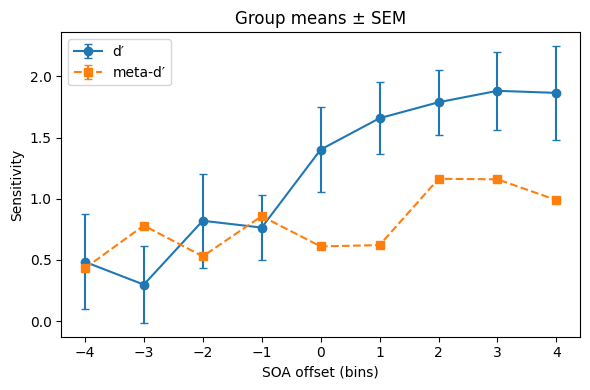

In [10]:
# 2) Group‐level means and SEM by SOA
grouped = summary.groupby('soa_offset').agg(
    mean_d   = ('dprime',      'mean'),
    sem_d    = ('dprime',      sem),
    mean_m   = ('meta_dprime', 'mean'),
    sem_m    = ('meta_dprime', sem)
).reset_index()

# 3) Plot group means with error bars
plt.figure(figsize=(6,4))
plt.errorbar(grouped['soa_offset'],
             grouped['mean_d'],
             yerr=grouped['sem_d'],
             fmt='o-', label="d′", capsize=3)
plt.errorbar(grouped['soa_offset'],
             grouped['mean_m'],
             yerr=grouped['sem_m'],
             fmt='s--', label="meta-d′", capsize=3)
plt.xlabel("SOA offset (bins)")
plt.ylabel("Sensitivity")
plt.title("Group means ± SEM")
plt.legend()
plt.tight_layout()
plt.show()

## Fit Logistic Psychometric Functions

C:\Users\Owner\AppData\Local\Temp\ipykernel_48904\2766442659.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, x, y, p0=p0, maxfev=5000)


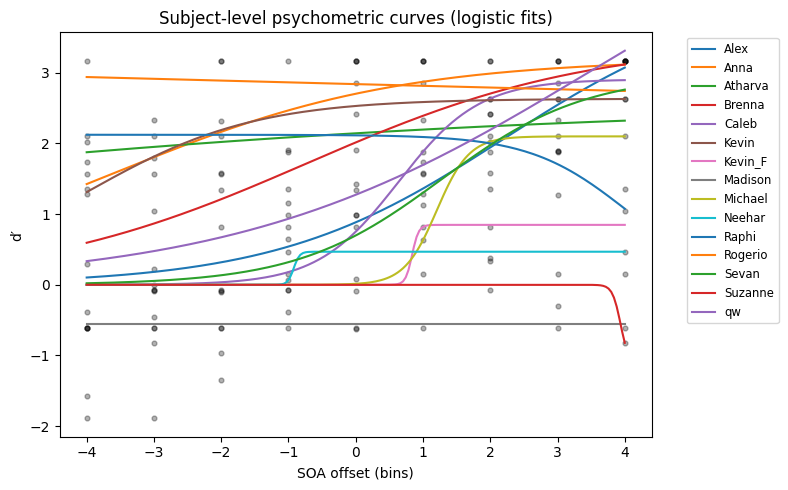

In [11]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k*(x - x0)))

params_d = {}
soa_min, soa_max = summary['soa_offset'].min(), summary['soa_offset'].max()
x_dense = np.linspace(soa_min, soa_max, 200)

plt.figure(figsize=(8,5))
for subj, grp in summary.groupby('subj'):
    x = grp['soa_offset'].values
    y = grp['dprime'].values
    # initial guesses: [asymptote, slope, midpoint]
    p0 = [np.nanmax(y), 1.0, np.median(x)]
    try:
        popt, _ = curve_fit(logistic, x, y, p0=p0, maxfev=5000)
    except:
        popt = [np.nan, np.nan, np.nan]
    params_d[subj] = popt
    plt.plot(x_dense, logistic(x_dense, *popt), label=subj)

plt.scatter(summary['soa_offset'], summary['dprime'],
            color='k', s=12, alpha=0.3)
plt.xlabel("SOA offset (bins)")
plt.ylabel("d′")
plt.title("Subject-level psychometric curves (logistic fits)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_48904\562862140.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)


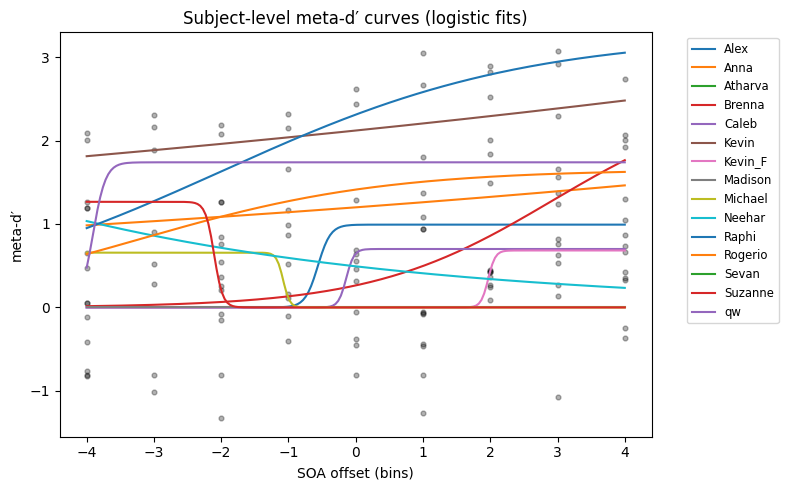

In [12]:
params_m = {}
plt.figure(figsize=(8,5))
for subj, grp in summary.groupby('subj'):
    x = grp['soa_offset'].values
    y = grp['meta_dprime'].values
    mask = ~np.isnan(y)
    if mask.sum() < 4:
        params_m[subj] = [np.nan, np.nan, np.nan]
        continue
    p0 = [np.nanmax(y[mask]), 1.0, np.median(x[mask])]
    try:
        popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)
    except:
        popt = [np.nan, np.nan, np.nan]
    params_m[subj] = popt
    plt.plot(x_dense, logistic(x_dense, *popt), label=subj)

plt.scatter(summary['soa_offset'], summary['meta_dprime'],
            color='k', s=12, alpha=0.3)
plt.xlabel("SOA offset (bins)")
plt.ylabel("meta-d′")
plt.title("Subject-level meta-d′ curves (logistic fits)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [13]:
soa_min, soa_max = summary['soa_offset'].min(), summary['soa_offset'].max()
x_dense = np.linspace(soa_min, soa_max, 200)

def plot_median_ci(summary, value_col, ylabel, title):
    # Fit per-subject logistics
    params = {}
    for subj, grp in summary.groupby('subj'):
        x = grp['soa_offset'].values
        y = grp[value_col].values
        mask = ~np.isnan(y)
        if value_col == 'meta_dprime' and mask.sum() < 4:
            params[subj] = [np.nan, np.nan, np.nan]
            continue
        p0 = [np.nanmax(y[mask]), 1.0, np.median(x[mask])]
        try:
            popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)
        except:
            popt = [np.nan, np.nan, np.nan]
        params[subj] = popt

    # Collect fitted curves
    fitted = np.array([
        logistic(x_dense, *p)
        for p in params.values()
        if not np.any(np.isnan(p))
    ])

    # Compute median and CI
    median = np.median(fitted, axis=0)
    lower = np.percentile(fitted, 2.5, axis=0)
    upper = np.percentile(fitted, 97.5, axis=0)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_dense, median)
    plt.fill_between(x_dense, lower, upper, alpha=0.3)
    plt.scatter(summary['soa_offset'], summary[value_col], s=12, alpha=0.3)
    plt.xlabel("SOA offset (bins)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_48904\2757811141.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)


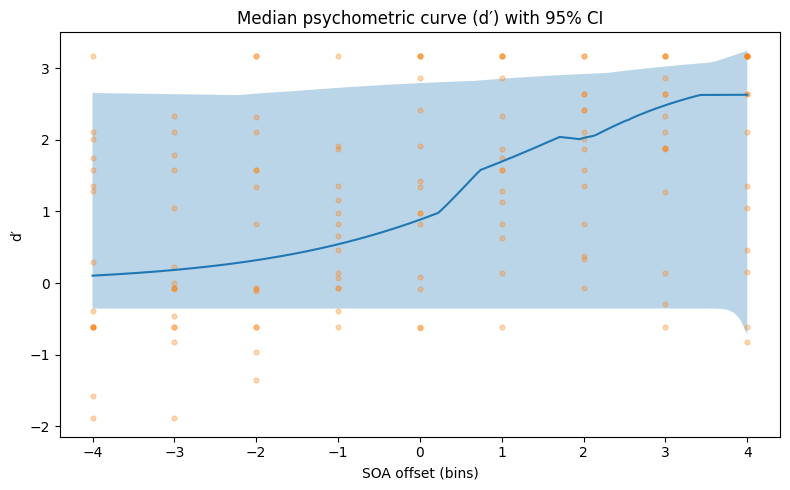

C:\Users\Owner\AppData\Local\Temp\ipykernel_48904\2757811141.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, x[mask], y[mask], p0=p0, maxfev=5000)


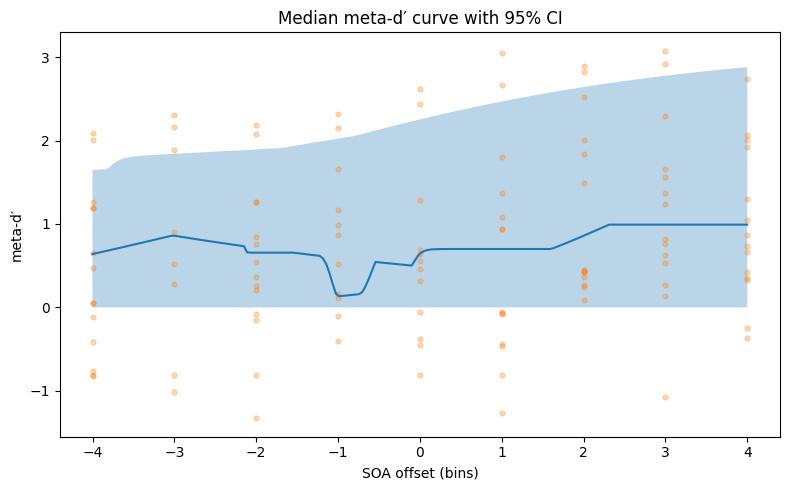

In [14]:
plot_median_ci(summary, 'dprime', "d′", "Median psychometric curve (d′) with 95% CI")

# Plot for meta-d′
plot_median_ci(summary, 'meta_dprime', "meta-d′", "Median meta-d′ curve with 95% CI")

In [ ]:
params_df = (
    pd.DataFrame.from_dict(params_d, orient='index', 
                           columns=['d_L','d_k','d_x0'])
      .join(pd.DataFrame.from_dict(params_m, orient='index',
               columns=['m_L','m_k','m_x0']))
      .reset_index()
      .rename(columns={'index':'subj'})
)
print(params_df.to_string(index=False))

   subj        d_L       d_k        d_x0          m_L        m_k       m_x0
   Alex   4.138041  0.590771    2.205576     0.992075  10.558540  -0.563627
   Anna   3.199880  0.478440   -3.542142  7154.380228   0.049607 175.248482
Atharva   2.571181  0.155284  -10.389630          NaN        NaN        NaN
 Brenna   3.446183  0.477256   -0.715694     2.562098   0.739391   2.927353
  Caleb   2.906710  1.662331    0.633437     0.700192  17.320892  -0.141274
  Kevin   2.633286  0.802787   -3.991584  2213.685875   0.039221 177.210533
Kevin_F   0.848005 20.679001    0.838043     0.682424  18.858352   1.969187
Madison  -0.548202  2.561307  -40.745613     0.169844   4.084377  14.318716
Michael   2.100150  4.145828    1.203385     0.656484 -20.405254  -1.079239
 Neehar   0.468181 23.078106   -0.922110 28118.641456  -0.185589 -59.014583
  Raphi   2.123073 -1.385189    4.020635     3.266415   0.443199  -1.990112
Rogerio 404.789871 -0.008727 -567.500480     1.653754   0.556394  -3.171910
  Sevan   2.